In [5]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import joblib

# Loading the dataset (test.csv)

In [6]:
data = pd.read_csv('test.csv')
print(data.shape)

data.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Dropping ID

In [7]:
data.drop(['Id', 'Alley', 'PoolQC', 'MiscFeature'], axis=1, inplace=True)

data.shape

(1459, 76)

# Feature Engineering

* **Missing Values**
* **Temporal Features**
* **Non-Gaussian distributed Features**
* **Categorical Features: Remove Rare Labels**
* **Categorical Features: Convert String to numbers**
* **Standardize the values of the variables to the same range**

## Missing Values

### Categorical Variables

* **Replace missing values with the string 'Missing' in those variables with a lot of missing data.**
* **Replace missing values with the most frequent category 'Mode' in those variables that contain few observations without values.**

In [8]:
# first we needed to cast MSSubClass as object

data['MSSubClass'] = data['MSSubClass'].astype('O')

In [14]:
# list of different groups of categorical variables

# with_string_missing = ['Alley', 'FireplaceQu',
#                        'PoolQC', 'Fence', 'MiscFeature']

with_string_missing = ['Fence']

# ==================
# we copy this dictionary from the Feature-engineering notebook
# note that we needed to hard-code this by hand

# the key is the variable and the value is its most frequent category

# what if we re-train the model and the below values change?
# ==================

with_frequent_category = {
    'MasVnrType': 'None',
    'BsmtQual': 'TA',
    'BsmtCond': 'TA',
    'BsmtExposure': 'No',
    'BsmtFinType1': 'Unf',
    'BsmtFinType2': 'Unf',
    'Electrical': 'SBrkr',
    'GarageType': 'Attchd',
    'GarageFinish': 'Unf',
    'GarageQual': 'TA',
    'GarageCond': 'TA',
}

In [15]:
# replace missing values with new label: "Missing"

data[with_string_missing] = data[with_string_missing].fillna('Missing')

In [16]:
# replace missing values with the most frequent category

for var in with_frequent_category.keys():
    data[var].fillna(with_frequent_category[var], inplace=True)

### Numerical variables

* **To engineer missing values in numerical variables, we will:**

* **add a binary missing value indicator variable**
* **and then replace the missing values in the original variable with the mean**


In [17]:
# this is the dictionary of numerical variable with missing data
# and its mean, as determined from the training set in the
# Feature Engineering notebook

# note how we needed to hard code the values

vars_with_na = {
    'LotFrontage': 69.87974098057354,
    'MasVnrArea': 103.7974006116208,
    'GarageYrBlt': 1978.2959677419356,
}

In [18]:
# replace missing values as we described above

for var in vars_with_na.keys():

    # add binary missing indicator (in train and test)
    data[var + '_na'] = np.where(data[var].isnull(), 1, 0)

    # replace missing values by the mean
    # (in train and test)
    data[var].fillna(vars_with_na[var], inplace=True)

data[vars_with_na].isnull().sum()

C:\Users\USER\AppData\Local\Temp\ipykernel_22068\2265030139.py:12: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  data[vars_with_na].isnull().sum()


LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

In [19]:
# check the binary missing indicator variables

data[['LotFrontage_na', 'MasVnrArea_na', 'GarageYrBlt_na']].head()

,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


### Temporal variables

#### Capture elapsed time

* **We need to capture the time elapsed between those variables and the year in which the house was sold:**

In [20]:
def elapsed_years(df, var):
    # capture difference between the year variable
    # and the year in which the house was sold
    df[var] = df['YrSold'] - df[var]
    return df

In [21]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    data = elapsed_years(data, var)

In [22]:
# now we drop YrSold
data.drop(['YrSold'], axis=1, inplace=True)

### Numerical variable transformation

#### Logarithmic transformation

* **We will transform with the logarithm the positive numerical variables in order to get a more Gaussian-like distribution.**

In [23]:
for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]:
    data[var] = np.log(data[var])

### Yeo - Johnson transformation

* **We will apply the Yeo-Johnson transformation to LotArea.**

In [24]:
# note how we use the lambda that we learned from the train set
# in the notebook on Feature Engineering.

# Note that we need to hard code this value

data['LotArea'] = stats.yeojohnson(data['LotArea'], lmbda=-12.55283001172003)

### Binarize skewed variables

* **There were a few variables very skewed, we would transform those into binary variables.**

In [25]:
skewed = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal'
]

for var in skewed:
    
    # map the variable values into 0 and 1
    data[var] = np.where(data[var]==0, 0, 1)

## Categorical variables (Applying Mappings as per data_description.txt)

* **We remap variables with specific meanings into a numerical scale.**

In [26]:
# re-map strings to numbers, which determine quality

qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
             'HeatingQC', 'KitchenQual', 'FireplaceQu',
             'GarageQual', 'GarageCond',
            ]

for var in qual_vars:
    data[var] = data[var].map(qual_mappings)


In [27]:
exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

var = 'BsmtExposure'

data[var] = data[var].map(exposure_mappings)

In [28]:
finish_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

finish_vars = ['BsmtFinType1', 'BsmtFinType2']

for var in finish_vars:
    data[var] = data[var].map(finish_mappings)

In [29]:
garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

var = 'GarageFinish'

data[var] = data[var].map(garage_mappings)

In [30]:
fence_mappings = {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

var = 'Fence'

data[var] = data[var].map(fence_mappings)

In [31]:

# check absence of na in the data set

with_null = [var for var in data.columns if data[var].isnull().sum() > 0]

with_null

['MSZoning',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageCars',
 'GarageArea',
 'SaleType']

### **Surprise: There are quite a few variables with missing data!!**

In [32]:
# did those have missing data in the train set?

[var for var in with_null if var in list(
    with_frequent_category.keys())+with_string_missing+list(vars_with_na.keys())]

[]

### IMPORTANT

* **In the new data, we have a bunch of variables that contain missing information, that we did not anticipate.**

### Removing Rare Labels

* **For the remaining categorical variables, we will group those categories that are present in less than 1% of the observations into a "Rare" string.**

In [35]:
frequent_ls = {
    'MSZoning': ['FV', 'RH', 'RL', 'RM'],
    'Street': ['Pave'],
#     'Alley': ['Grvl', 'Missing', 'Pave'],
    'LotShape': ['IR1', 'IR2', 'Reg'],
    'LandContour': ['Bnk', 'HLS', 'Low', 'Lvl'],
    'Utilities': ['AllPub'],
    'LotConfig': ['Corner', 'CulDSac', 'FR2', 'Inside'],
    'LandSlope': ['Gtl', 'Mod'],
    'Neighborhood': ['Blmngtn', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor',
                     'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NWAmes',
                     'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW',
                     'Somerst', 'StoneBr', 'Timber'],

    'Condition1': ['Artery', 'Feedr', 'Norm', 'PosN', 'RRAn'],
    'Condition2': ['Norm'],
    'BldgType': ['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE'],
    'HouseStyle': ['1.5Fin', '1Story', '2Story', 'SFoyer', 'SLvl'],
    'RoofStyle': ['Gable', 'Hip'],
    'RoofMatl': ['CompShg'],
    'Exterior1st': ['AsbShng', 'BrkFace', 'CemntBd', 'HdBoard', 'MetalSd', 'Plywood',
                    'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing'],

    'Exterior2nd': ['AsbShng', 'BrkFace', 'CmentBd', 'HdBoard', 'MetalSd', 'Plywood',
                    'Stucco', 'VinylSd', 'Wd Sdng', 'Wd Shng'],

    'MasVnrType': ['BrkFace', 'None', 'Stone'],
    'Foundation': ['BrkTil', 'CBlock', 'PConc', 'Slab'],
    'Heating': ['GasA', 'GasW'],
    'CentralAir': ['N', 'Y'],
    'Electrical': ['FuseA', 'FuseF', 'SBrkr'],
    'Functional': ['Min1', 'Min2', 'Mod', 'Typ'],
    'GarageType': ['Attchd', 'Basment', 'BuiltIn', 'Detchd'],
    'PavedDrive': ['N', 'P', 'Y'],
#     'PoolQC': ['Missing'],
#     'MiscFeature': ['Missing', 'Shed'],
    'SaleType': ['COD', 'New', 'WD'],
    'SaleCondition': ['Abnorml', 'Family', 'Normal', 'Partial'],
    'MSSubClass': ['20', '30', '50', '60', '70', '75', '80', '85', '90', '120', '160', '190'],
}

In [36]:
for var in frequent_ls.keys():
    
    # replace rare categories by the string "Rare"
    data[var] = np.where(data[var].isin(
        frequent_ls), data[var], 'Rare')

### Encoding of categorical variables

* **Next, we need to transform the strings of the categorical variables into numbers.**

In [40]:
# we need the mappings learned from the train set. Otherwise, our model is going
# to produce inaccurate results

# note the amount of hard coding that we need to do.

# Can you think of an alternative? 

# Perhaps we could have save this as a numpy pickle
# and load it here, instead of hard-coding.

# But that means that we need to go back to the Feature Engineering notebook, and change
# the code so that we store the pickle. So there is still some code changes that we need

ordinal_mappings = {
    'MSZoning': {'Rare': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4},
    'Street': {'Rare': 0, 'Pave': 1},
#     'Alley': {'Grvl': 0, 'Pave': 1, 'Missing': 2},
    'LotShape': {'Reg': 0, 'IR1': 1, 'Rare': 2, 'IR2': 3},
    'LandContour': {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3},
    'Utilities': {'Rare': 0, 'AllPub': 1},
    'LotConfig': {'Inside': 0, 'FR2': 1, 'Corner': 2, 'Rare': 3, 'CulDSac': 4},
    'LandSlope': {'Gtl': 0, 'Mod': 1, 'Rare': 2},
    'Neighborhood': {'IDOTRR': 0, 'MeadowV': 1, 'BrDale': 2, 'Edwards': 3,
                     'BrkSide': 4, 'OldTown': 5, 'Sawyer': 6, 'SWISU': 7,
                     'NAmes': 8, 'Mitchel': 9, 'SawyerW': 10, 'Rare': 11,
                     'NWAmes': 12, 'Gilbert': 13, 'Blmngtn': 14, 'CollgCr': 15,
                     'Crawfor': 16, 'ClearCr': 17, 'Somerst': 18, 'Timber': 19,
                     'StoneBr': 20, 'NridgHt': 21, 'NoRidge': 22},
    
    'Condition1': {'Artery': 0, 'Feedr': 1, 'Norm': 2, 'RRAn': 3, 'Rare': 4, 'PosN': 5},
    'Condition2': {'Rare': 0, 'Norm': 1},
    'BldgType': {'2fmCon': 0, 'Duplex': 1, 'Twnhs': 2, '1Fam': 3, 'TwnhsE': 4},
    'HouseStyle': {'SFoyer': 0, '1.5Fin': 1, 'Rare': 2, '1Story': 3, 'SLvl': 4, '2Story': 5},
    'RoofStyle': {'Gable': 0, 'Rare': 1, 'Hip': 2},
    'RoofMatl': {'CompShg': 0, 'Rare': 1},
    'Exterior1st': {'AsbShng': 0, 'Wd Sdng': 1, 'WdShing': 2, 'MetalSd': 3,
                    'Stucco': 4, 'Rare': 5, 'HdBoard': 6, 'Plywood': 7,
                    'BrkFace': 8, 'CemntBd': 9, 'VinylSd': 10},
    
    'Exterior2nd': {'AsbShng': 0, 'Wd Sdng': 1, 'MetalSd': 2, 'Wd Shng': 3,
                    'Stucco': 4, 'Rare': 5, 'HdBoard': 6, 'Plywood': 7,
                    'BrkFace': 8, 'CmentBd': 9, 'VinylSd': 10},
    
    'MasVnrType': {'Rare': 0, 'None': 1, 'BrkFace': 2, 'Stone': 3},
    'Foundation': {'Slab': 0, 'BrkTil': 1, 'CBlock': 2, 'Rare': 3, 'PConc': 4},
    'Heating': {'Rare': 0, 'GasW': 1, 'GasA': 2},
    'CentralAir': {'N': 0, 'Y': 1},
    'Electrical': {'Rare': 0, 'FuseF': 1, 'FuseA': 2, 'SBrkr': 3},
    'Functional': {'Rare': 0, 'Min2': 1, 'Mod': 2, 'Min1': 3, 'Typ': 4},
    'GarageType': {'Rare': 0, 'Detchd': 1, 'Basment': 2, 'Attchd': 3, 'BuiltIn': 4},
    'PavedDrive': {'N': 0, 'P': 1, 'Y': 2},
#     'PoolQC': {'Missing': 0, 'Rare': 1},
#     'MiscFeature': {'Rare': 0, 'Shed': 1, 'Missing': 2},
    'SaleType': {'COD': 0, 'Rare': 1, 'WD': 2, 'New': 3},
    'SaleCondition': {'Rare': 0, 'Abnorml': 1, 'Family': 2, 'Normal': 3, 'Partial': 4},
    'MSSubClass': {'30': 0, 'Rare': 1, '190': 2, '90': 3, '160': 4, '50': 5, '85': 6,
                   '70': 7, '80': 8, '20': 9, '75': 10, '120': 11, '60': 12},
}

In [41]:
for var in ordinal_mappings.keys():

    ordinal_label = ordinal_mappings[var]

    # use the dictionary to replace the categorical strings by integers
    data[var] = data[var].map(ordinal_label)

In [42]:
# check absence of na in the data set

with_null = [var for var in data.columns if data[var].isnull().sum() > 0]

len(with_null)

15

In [43]:
# there is missing data in a lot of the variables.

# unfortunately, the scaler wil not work with missing data, so
# we need to fill those values

# in the real world, we would try to understand where they are coming from
# and why they were not present in the training set

# here I will just fill them in quickly to proceed with the demo

data.fillna(0, inplace=True)

# Feature Scaling

* **We will scale features to the minimum and maximum values:**

In [44]:
# load the scaler we saved in the notebook on Feature Engineering

# fortunataly, we were smart and we saved it, but this is an easy step
# to forget

scaler = joblib.load('minmax_scalar.joblib') 

data = pd.DataFrame(
    scaler.transform(data),
    columns=data.columns
)

In [45]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,0.083333,0.0,0.495064,0.0,0.0,0.666667,0.0,0.0,0.75,1.0,...,1.0,0.0,0.75,0.0,0.454545,0.333333,0.0,0.0,0.0,0.0
1,0.083333,0.0,0.499662,0.0,0.0,0.666667,0.0,0.0,0.75,1.0,...,0.0,0.0,0.00,1.0,0.454545,0.333333,0.0,0.0,0.0,0.0
2,0.083333,0.0,0.466207,0.0,0.0,0.666667,0.0,0.0,0.75,1.0,...,0.0,0.0,0.75,0.0,0.181818,0.333333,0.0,0.0,0.0,0.0
3,0.083333,0.0,0.485693,0.0,0.0,0.666667,0.0,0.0,0.75,1.0,...,0.0,0.0,0.00,0.0,0.454545,0.333333,0.0,0.0,0.0,0.0
4,0.083333,0.0,0.265271,0.0,0.0,0.666667,0.0,0.0,0.75,1.0,...,1.0,0.0,0.00,0.0,0.000000,0.333333,0.0,0.0,0.0,0.0


In [46]:
# load the pre-selected features
# ==============================

features = pd.read_csv('selected_features.csv')
features = features['0'].to_list() 

# reduce the train and test set to the selected features
data = data[features]

data.shape

(1459, 36)

# Fitting the model and getting predictions on test_data.csv

In [66]:
X_train = pd.read_csv('xtrain.csv')
X_test = pd.read_csv('xtest.csv')

y_train = pd.read_csv('ytrain.csv')
y_test = pd.read_csv('ytest.csv')

features = pd.read_csv('selected_features.csv')
features = features['0'].to_list()

X_train = X_train[features]
X_test = X_test[features]

In [71]:
X_train.shape

(1314, 36)

In [72]:
import tensorflow as tf

In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [74]:
model = Sequential()

model.add(Dense(36, activation = 'relu'))
model.add(Dense(36, activation = 'relu'))
model.add(Dense(36, activation = 'relu'))
model.add(Dense(36, activation = 'relu'))

In [75]:
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

In [76]:
model.fit(x = X_train, y = y_train, validation_data = (X_test, y_test), batch_size = 128, epochs = 400)

Epoch 1/400
11/11 [==============================] - 0s 17ms/step - loss: 131.0897 - val_loss: 116.2279
Epoch 2/400
11/11 [==============================] - 0s 7ms/step - loss: 100.8615 - val_loss: 74.3786
Epoch 3/400
11/11 [==============================] - 0s 8ms/step - loss: 51.0736 - val_loss: 17.4598
Epoch 4/400
11/11 [==============================] - 0s 8ms/step - loss: 8.6625 - val_loss: 9.1262
Epoch 5/400
11/11 [==============================] - 0s 8ms/step - loss: 7.3883 - val_loss: 2.8564
Epoch 6/400
11/11 [==============================] - 0s 7ms/step - loss: 4.1221 - val_loss: 2.9940
Epoch 7/400
11/11 [==============================] - 0s 8ms/step - loss: 3.1363 - val_loss: 2.0641
Epoch 8/400
11/11 [==============================] - 0s 8ms/step - loss: 2.4839 - val_loss: 1.5157
Epoch 9/400
11/11 [==============================] - 0s 8ms/step - loss: 1.8434 - val_loss: 1.1984
Epoch 10/400
11/11 [==============================] - 0s 8ms/step - loss: 1.4722 - val_loss: 0.9915

Epoch 83/400
11/11 [==============================] - 0s 6ms/step - loss: 0.0637 - val_loss: 0.1275
Epoch 84/400
11/11 [==============================] - 0s 7ms/step - loss: 0.0611 - val_loss: 0.1245
Epoch 85/400
11/11 [==============================] - 0s 6ms/step - loss: 0.0608 - val_loss: 0.1211
Epoch 86/400
11/11 [==============================] - 0s 6ms/step - loss: 0.0598 - val_loss: 0.1192
Epoch 87/400
11/11 [==============================] - 0s 6ms/step - loss: 0.0579 - val_loss: 0.1194
Epoch 88/400
11/11 [==============================] - 0s 6ms/step - loss: 0.0571 - val_loss: 0.1168
Epoch 89/400
11/11 [==============================] - 0s 6ms/step - loss: 0.0555 - val_loss: 0.1189
Epoch 90/400
11/11 [==============================] - 0s 8ms/step - loss: 0.0570 - val_loss: 0.1129
Epoch 91/400
11/11 [==============================] - 0s 7ms/step - loss: 0.0551 - val_loss: 0.1189
Epoch 92/400
11/11 [==============================] - 0s 7ms/step - loss: 0.0540 - val_loss: 0.1112


11/11 [==============================] - 0s 8ms/step - loss: 0.0199 - val_loss: 0.0413
Epoch 165/400
11/11 [==============================] - 0s 8ms/step - loss: 0.0203 - val_loss: 0.0409
Epoch 166/400
11/11 [==============================] - 0s 9ms/step - loss: 0.0183 - val_loss: 0.0420
Epoch 167/400
11/11 [==============================] - 0s 8ms/step - loss: 0.0180 - val_loss: 0.0415
Epoch 168/400
11/11 [==============================] - 0s 6ms/step - loss: 0.0181 - val_loss: 0.0388
Epoch 169/400
11/11 [==============================] - 0s 6ms/step - loss: 0.0181 - val_loss: 0.0379
Epoch 170/400
11/11 [==============================] - 0s 6ms/step - loss: 0.0185 - val_loss: 0.0386
Epoch 171/400
11/11 [==============================] - 0s 7ms/step - loss: 0.0187 - val_loss: 0.0477
Epoch 172/400
11/11 [==============================] - 0s 7ms/step - loss: 0.0189 - val_loss: 0.0454
Epoch 173/400
11/11 [==============================] - 0s 7ms/step - loss: 0.0206 - val_loss: 0.0388
Epoc

11/11 [==============================] - 0s 7ms/step - loss: 0.0134 - val_loss: 0.0305
Epoch 246/400
11/11 [==============================] - 0s 7ms/step - loss: 0.0140 - val_loss: 0.0292
Epoch 247/400
11/11 [==============================] - 0s 7ms/step - loss: 0.0146 - val_loss: 0.0299
Epoch 248/400
11/11 [==============================] - 0s 6ms/step - loss: 0.0140 - val_loss: 0.0292
Epoch 249/400
11/11 [==============================] - 0s 7ms/step - loss: 0.0130 - val_loss: 0.0298
Epoch 250/400
11/11 [==============================] - 0s 7ms/step - loss: 0.0142 - val_loss: 0.0341
Epoch 251/400
11/11 [==============================] - 0s 6ms/step - loss: 0.0151 - val_loss: 0.0303
Epoch 252/400
11/11 [==============================] - 0s 6ms/step - loss: 0.0132 - val_loss: 0.0364
Epoch 253/400
11/11 [==============================] - 0s 6ms/step - loss: 0.0148 - val_loss: 0.0301
Epoch 254/400
11/11 [==============================] - 0s 7ms/step - loss: 0.0152 - val_loss: 0.0288
Epoc

11/11 [==============================] - 0s 6ms/step - loss: 0.0119 - val_loss: 0.0255
Epoch 327/400
11/11 [==============================] - 0s 8ms/step - loss: 0.0132 - val_loss: 0.0271
Epoch 328/400
11/11 [==============================] - 0s 7ms/step - loss: 0.0121 - val_loss: 0.0295
Epoch 329/400
11/11 [==============================] - 0s 7ms/step - loss: 0.0135 - val_loss: 0.0287
Epoch 330/400
11/11 [==============================] - 0s 6ms/step - loss: 0.0134 - val_loss: 0.0341
Epoch 331/400
11/11 [==============================] - 0s 6ms/step - loss: 0.0150 - val_loss: 0.0300
Epoch 332/400
11/11 [==============================] - 0s 6ms/step - loss: 0.0145 - val_loss: 0.0277
Epoch 333/400
11/11 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 0.0296
Epoch 334/400
11/11 [==============================] - 0s 7ms/step - loss: 0.0127 - val_loss: 0.0273
Epoch 335/400
11/11 [==============================] - 0s 7ms/step - loss: 0.0116 - val_loss: 0.0328
Epoc

<AxesSubplot:>

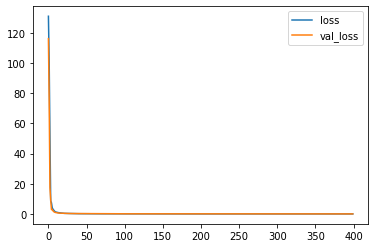

In [77]:
losses = pd.DataFrame(model.history.history) # Gives both training loss and validation loss
losses.plot() # training loss and validation loss vs epochs

In [79]:
data

,MSSubClass,MSZoning,LotFrontage,LotShape,LandContour,LotConfig,Neighborhood,OverallQual,OverallCond,YearRemodAdd,...,Functional,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,ScreenPorch,SaleCondition
0,0.083333,0.0,0.495064,0.666667,0.0,0.75,0.5,0.444444,0.625,0.819672,...,0.0,0.000000,0.0,0.0,0.25,0.514810,0.0,0.163361,1.0,0.0
1,0.083333,0.0,0.499662,0.666667,0.0,0.75,0.5,0.555556,0.625,0.868852,...,0.0,0.000000,0.0,0.0,0.25,0.220028,0.0,0.458576,0.0,0.0
2,0.083333,0.0,0.466207,0.666667,0.0,0.75,0.5,0.444444,0.500,0.213115,...,0.0,0.333333,0.6,1.0,0.50,0.339915,0.0,0.247375,0.0,0.0
3,0.083333,0.0,0.485693,0.666667,0.0,0.75,0.5,0.555556,0.625,0.213115,...,0.0,0.333333,0.8,1.0,0.50,0.331453,0.0,0.420070,0.0,0.0
4,0.083333,0.0,0.265271,0.666667,0.0,0.75,0.5,0.777778,0.500,0.311475,...,0.0,0.000000,0.0,0.5,0.50,0.356841,0.0,0.000000,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0.083333,0.0,0.000000,0.666667,0.0,0.75,0.5,0.333333,0.750,0.606557,...,0.0,0.000000,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0
1455,0.083333,0.0,0.000000,0.666667,0.0,0.75,0.5,0.333333,0.500,0.606557,...,0.0,0.000000,0.0,0.0,0.25,0.201693,0.0,0.000000,0.0,0.0
1456,0.083333,0.0,0.751625,0.666667,0.0,0.75,0.5,0.444444,0.750,0.180328,...,0.0,0.333333,0.6,0.0,0.50,0.406206,0.0,0.553092,0.0,0.0
1457,0.083333,0.0,0.400718,0.666667,0.0,0.75,0.5,0.444444,0.500,0.245902,...,0.0,0.000000,0.0,0.0,0.00,0.000000,0.0,0.093349,0.0,0.0


In [80]:
ann_predict = model.predict(data)

In [83]:
ann_predict

array([[10.016543],
       [10.89189 ],
       [10.270632],
       ...,
       [11.172193],
       [10.062473],
       [10.24206 ]], dtype=float32)

In [84]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.shape

(1459, 2)

In [93]:
ann_predict.flatten()

array([10.016543, 10.89189 , 10.270632, ..., 11.172193, 10.062473,
       10.24206 ], dtype=float32)

In [94]:
sample_submission['SalePrice'] = pd.Series(np.exp(ann_predict.flatten()))

In [95]:
sample_submission

,Id,SalePrice
0,1461,22393.888672
1,1462,53738.750000
2,1463,28872.123047
3,1464,35443.957031
4,1465,29853.546875
...,...,...
1454,2915,33601.152344
1455,2916,16214.123047
1456,2917,71124.890625
1457,2918,23446.423828


In [96]:
sample_submission.to_csv('sample_submission.csv', index=False)

<AxesSubplot:>

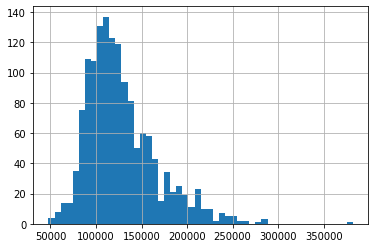

In [97]:
pd.Series(np.exp(pred)).hist(bins=50)